In [93]:
# Author: Afif Shomali
# Imports & loading dataset
import pandas as pd
import numpy as np
import ast
import re
from tqdm.auto import tqdm
import requests
from textstat import flesch_reading_ease

# Imports for sentiment of reviews
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
import langdetect
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Afif\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Afif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [94]:
df = pd.read_csv("Datasets/AirbnbData/All_Listings_Cleaned.csv")

# Feature Engineering for the Airbnb Dataset
Source: Inside Airbnb accessed at https://insideairbnb.com/get-the-data/ (Used New York City Datasets, used listings & reviews data)  
License : [Creative Commons Attribution 4.0 International License](#https://creativecommons.org/licenses/by/4.0/)

The listings dataset being used is one that has combined multiple months of data from Inside Airbnb, addtionaly, data preprocessing & cleaning was performed, see `PreProcessingAirbnb.ipynb` to see what changes were made.


Steps overview:
  - [Create Feautres based on the host verifications](#host-verification-status)
  - [Create Features based on the amenities list](#amenities-column)
  - [Using Reviews data, get sentiment of each review, the for each host create a review score column (use average/some sort of metric based on counts of sentiments), impute values for any hosts with no reviews](#creating-column-based-on-sentiment-of-reviews)
  - [Extra: Try to create a Description/Title/host description/neighborhood overview column score based on the text from these columns, create some sort of metric that combines these into a new column](#creating-features-for-text-from-descriptiontitlehost-descriptionneighborhood-overview)
  - [Extra: Create a Feature that takes the listing photo and assigns it some sort of rating](#creating-a-feature-based-on-a-rating-of-listing-photos)

## Host Verification Status

Since there are only 3 types of verification methods (phone, email, work_email), we can either create 3 binary columns or create a column that counts the number of verification methods. Some EDA will be done later to check which of these two options is better by comparing to the 2 response variables we will use later on in the analysis, Price & whether the host is a superhost.

In [95]:
# Change column of strings to column lists
df["host_verifications"] = df["host_verifications"].apply(ast.literal_eval)

# Create column for number of verifications the host has
df["num_host_verifications"] = df["host_verifications"].apply(len)

# Create columns for which types of verifications the host has
df["host_phone_verified"] = df["host_verifications"].apply(lambda x: 'phone' in x)
df["host_email_verified"] = df["host_verifications"].apply(lambda x: 'email' in x)
df["host_work_email_verified"] = df["host_verifications"].apply(lambda x: 'work_email' in x)


## Amenities Column 

We see that there are over 7000 variations (e.g. unique values) of amenities, so we have a few options, we can make a column that counts the number of amenities, or  
since alot of the ammenities in the set describe the same amenity with some variation (e.g. HDTV with streaming services, kitchen, oven, etc.), we can take a subset of amenities to create binary columns for to check if a listing has those amenities.  
For example, most of the elements of the amenities set below are just HDTV followed by a list of streaming services, we can make columns for if a listing contains a tv or if it contains contains a certain streaming service.
Also we can simplify specific brands of appliances to just one column (e.g. oven, stove, fridge) and things such as shampoo, soap & conditioner.

Here is the list of amenites we will create columns for after going through the set of amenities:
- kitchen 
- oven
- stove
- refrigerator
- air conditioning
- sound system
- wifi
- tv
- parking
- gym/exercise equipment 
- pool
- hygeine products (soap, shampoo, or conditioner)
- laundry (if a listing contains a washer or dryer)
- coffee 
- view


In [ ]:
# Finding the unique values of ammenties
amenities_set = set()

for x in df["amenities"]:
    amen_list = ast.literal_eval(x)
    amen_list = [x.lower().strip() for x in amen_list]
    amenities_set.update(amen_list)
print(len(amenities_set))
# pprint.pprint(amenities_set)

In [ ]:
# First convert amenities column to list of string all lowercase with no leading/trailing spaces
df["amenities"] = df["amenities"].apply(ast.literal_eval).apply(lambda x: [amen.lower().strip() for amen in x])

# Create total amenity count column
df["num_amenities"] = df["amenities"].apply(len)

# Create indivual amenity binary columns
# Helper function, for each row checks for the keywords corresponding to the subset of ammenities
# If the keyword is present in the amenities list, then the corresponding amenity column is labeled as true
def populate_amens(row):
    for amen in short_amenities.keys():

        for keyword in short_amenities[amen]:
            if any(re.search(r'\b' + re.escape(keyword) + r'\b', row_amens) for row_amens in row["amenities"]):
                row[amen] = True
    return row

# Dict of amenities to make columns for and their corresponding keywords  
short_amenities = {
    "kitchen": ["kitchen"], 
    "oven": ["oven"], 
    "stove": ["stove"], 
    "refrigerator": ["refrigerator", "fridge"], 
    "air conditioning": ["air conditioning", "ac"], 
    "sound system": ["sound system"], 
    "wifi": ["wifi"], 
    "tv": ["hdtv", "tv"], 
    "parking": ["parking", "garage"], 
    "gym/exercise equipment": ["gym", "exercise equipment"], 
    "pool" : ["pool"], 
    "hygiene products": ["soap", "shampoo", "conditioner"], 
    "laundry" : ["washer", "dryer"], 
    "coffee" : ["coffee"], 
    "view" : ["view"]
}

# Initalize columns
for amen in short_amenities.keys():
    df[amen]  = False

# Apply helper function
df = df.apply(
    lambda row : populate_amens(row),
    axis = 1
)

## Creating Column Based on Sentiment of Reviews
**NOTE: using a reduced version of the dataset for the project submission so there won't be as many rows**  
Want to start by combining the datasets & omitting duplicate reviews by using the id column in the reviews datasets. 
Then want to do some partial pre-processing 

We will use Vader to process the sentiment of reviews:  
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

I roughly followed the steps in:
https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vaderSentiment.py#L517 

Some of the reviews are not in English, Vader can only do sentiment analysis on English text  
so we will make use of python langdetect library to drop the non english reviews 

Originally the plan was to translate reviews, however with around 100k non english reviews it was difficult to find an efficient way to do so.  
Using the googletrans library, I ran into issues with either having too many requests or having to large of a request.  
Using EasyNMT I ran into issues first with GPU memory limits running on kaggle, then trying with a better gpu in terms of memory on GCP I ran into issues with
the speed of running the model would take around 24 hours.

This does reduce our reviews dataset size by around 10% however it shouldn't cause too many issues since we still have nearly a million reviews 

Some listings will not have any reviews, however this won't be an issue since I am planning to use the average compound sentiment score which 
is a normalized score from -1 to 1, with zero being neutral, so hosts without any reviews will receive a zero average compound score making the sentiment 
of their reviews netural which makes the most sense from the perspective of replacing missing values.

In [99]:
# Combine Datasets
# Merging Step, don't run this part if only using subset
reviews = pd.read_csv("Datasets/AirbnbReviews/SepReviews.csv")

# print(reviews.shape)

# months = ["Aug", "July", "June", "May"]

# for month in months:
#     df_2 = pd.read_csv(f"Datasets/AirbnbReviews/{month}Reviews.csv")
    
#     reviews = pd.concat([
#         reviews, 
#         df_2[df_2["id"].isin(reviews["id"]) == False]
#     ]
#     ).reset_index(drop=True)

# print(reviews.shape)

# # Fill N/A or blank comments with empty string
# reviews["comments"] = reviews["comments"].fillna(" ")

# # Only keep columns relevant to reviews, which is listing_id, id & comments
# reviews = reviews[["listing_id", "id", "comments"]]

reviews.head()

(947328, 6)
(1040567, 6)


,listing_id,id,comments
0,2595,17857,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,2595,19176,Great experience.
2,2595,19760,I've stayed with my friend at the Midtown Cast...
3,2595,34320,"We've been staying here for about 9 nights, en..."
4,2595,46312,We had a wonderful stay at Jennifer's charming...


In [ ]:
# Find non-English reviews & drop them from the dataset
# Use parallelization to speed up the process, gets us from around 400 it/s to 2000 it/s

# Set language dection seed for consistency
langdetect.DetectorFactory.seed = 0

# Helper Function to find non english comments
def non_english(text):
    try:
        lang = langdetect.detect(text)
    except langdetect.LangDetectException:
        lang = "en"
    return lang != "en"

# Find the indices & the corresponding comments in the dataframe in parallel
non_english_idxs = Parallel(n_jobs=-1)(
    delayed(non_english)(comment) for comment in tqdm(reviews['comments'], desc="Detecting non-English comments")
)

Detecting non-English comments:   0%|          | 0/1040567 [00:00<?, ?it/s]

In [ ]:
non_english_idxs.sum()

In [ ]:
#  Remove non-english reviews
reviews['non_english'] = non_english_idxs
reviews = reviews[reviews['non_english'] == False].drop(columns="non_english").reset_index(drop=True)

In [ ]:
# Make a Review sentiment metric column using sentence tokeninzation

# Helper function 
def calculate_sentiment(text, analyzer):
    text = text.replace("\r<br/>", " ")

    sentence_list = nltk.tokenize.sent_tokenize(text)

    if len(sentence_list) == 0 or text == "Blank":
        return 0.0
    
    paragraphSentiments = 0.0
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        paragraphSentiments += vs["compound"]
    
    return paragraphSentiments/len(sentence_list)

analyzer = SIA()

# Calculate sentiments of each review in parallel 
sentiments = Parallel(n_jobs=-1)(
    delayed(calculate_sentiment)(comment, analyzer) for comment in tqdm(reviews['comments'], desc="Calculating Sentiments")
)

Calculating Sentiments:   0%|          | 0/910365 [00:00<?, ?it/s]

In [103]:
# Add sentiments to reviews dataframe & drop unneeded cols
reviews["average_review_sentiment_score"] = sentiments

reviews = reviews.drop(columns=["id", "comments"])

In [104]:
# Aggregate by listing_id so the listing get an average score
grouped = reviews.groupby("listing_id").mean().reset_index()

# Merge/Join Reviews to main dataset
df = pd.merge(df, grouped, left_on='id', right_on='listing_id', how="left")
df.fillna({'average_review_sentiment_score': 0}, inplace=True)

## Creating Feature(s) for text from Description/Title/host about/neighborhood overview

There are some more text features in this dataset that could be used to derive a numerical feature based on some sort of rating of the text. 
Using sentiment analysis is one option here, another potential option would be to use a readability metric such as Flesch-Kincaid Grade Level, Gunning Fog Index, etc.

I think for the description, assigning a readability score will be best as we want the description to be as easy to read for anyone looking to rent an airbnb, include those who don't speak English as their first language.   

While for Title/name of the listing I think sentiment analysis would be best since we would want to assign titles with positive sentienment higher scores as they are more likely to catch a customers eye and draw them to potetially booking that airbnb.
Similarly for the host about I think sentiment analysis score would be a good metric too since we would want a positive sound host about to draw in more customer.  

For neighborhood overview, I think it would be good do a combination of a readbility and sentiment metric, so I will take the sentiment analysis score along with a normalize Flesch Reading Ease to create a neighbourhood overview metric. 
I chose the Flesch Reading Ease metric since it is a continous variable so it will be easier to normalize and combine with the sentiment score.

In [ ]:
# Helper Functions, norm parameter is used so that we can combine the readability score with the normalized sentiment score
# Norm makes the readbility score normalize nicely when normalizing between -1 and 1, 
# so that a Blank neighbourhood overview gets combined review + sentiment score of zero
def calculate_readability(text, norm): 
    text = text.replace("\r<br/>", " ")
    if text == "Blank" and norm:
        return 50.0
    if text == "Blank":
        return 0.0
    return max(min(100.0, flesch_reading_ease(text)), 0.0) 

# Calculate Readability of description, 
desc_scores = Parallel(n_jobs=-1)(
    delayed(calculate_readability)(desc, False) for desc in tqdm(df["description"], desc="Calculating Description Readability")
)

df["description_FRES_score"] = desc_scores

Calculating Description Readability:   0%|          | 0/42430 [00:00<?, ?it/s]

In [106]:
# Sentiment for title
analyzer = SIA()
title_sentiments =  Parallel(n_jobs=-1)(
    delayed(calculate_sentiment)(title, analyzer) for title in tqdm(df['name'], desc="Calculating Title Sentiments")
)

df["title_sentiment_score"] = title_sentiments

Calculating Title Sentiments:   0%|          | 0/42430 [00:00<?, ?it/s]

In [107]:
# Sentiment for host about
host_about_sentiments =  Parallel(n_jobs=-1)(
    delayed(calculate_sentiment)(title, analyzer) for title in tqdm(df["host_about"], desc="Calculating host about Sentiments")
)

df["host_about_sentiment_score"] = host_about_sentiments

Calculating host about Sentiments:   0%|          | 0/42430 [00:00<?, ?it/s]

In [108]:
# Combined metric for neighbourhood overview
neighbourhood_sentiments =  Parallel(n_jobs=-1)(
    delayed(calculate_sentiment)(overview, analyzer) for overview in tqdm(df['neighborhood_overview'], desc="Calculating Neighbourhood Sentiments")
)

neighbourhood_readability =  Parallel(n_jobs=-1)(
    delayed(calculate_readability)(overview, True) for overview in tqdm(df["neighborhood_overview"], desc="Calculating Neighbourhood Readability")
)


# Normalize readability between -1 and 1 
min_val = min(neighbourhood_readability)
max_val = max(neighbourhood_readability)

neighbourhood_readability = [(2 * (x - min_val) / (max_val - min_val)) - 1 for x in neighbourhood_readability]

# Combine metrics using average
df["neighborhood_overview_score"] = [(a + b) / 2 for a, b in zip(neighbourhood_sentiments, neighbourhood_readability)]

Calculating Neighbourhood Sentiments:   0%|          | 0/42430 [00:00<?, ?it/s]

Calculating Neighbourhood Readability:   0%|          | 0/42430 [00:00<?, ?it/s]

In [110]:
# Drop columns that we no longer need & save the final dataset
# 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_name', 'host_about', 'host_verifications', 'bathrooms_text', 'amenities', 'listing_id',
# df = pd.read_csv("Datasets/AirbnbData/Feature_Engineered_Airbnb.csv")

# df.drop(columns=['name', 'description', 'neighborhood_overview', 'picture_url', 'host_name', 'host_about', 'host_verifications', 'bathrooms_text', 'amenities', 'listing_id'], inplace=True)

# df.to_csv("Datasets/AirbnbData/Feature_Engineered_Airbnb.csv", index=False)

## Extra, Not used in Final Analysis: Creating a Feature Based on a rating of listing photos

Each of the listings has picture url which is a photo the user sees when scrolling through potential listings, I think a feature that assigns a numerical value to these photos could be useful in our later analysis. 
EveryPixel has two models for scoring Images, User Generated Content (UGC) photo scoring and Stock photo scoring:  

https://labs.everypixel.com/help#article_5  
https://labs.everypixel.com/help#article_4  

I will be using their API to create a new column that rates the photo, I chose to use the UCG scoring based on the description of the score:   
"This model is designed to score user photos taken with both a professional camera and a smartphone camera. It doesn't evaluate the action and doesn't measure how cool or beautiful a person or object looks in a photo. It only cares about technical parts like brightness, contrast, noise, and so on. The service is not designed to rate historical photos, illustrations, or 3D visualizations."

I think this score is more relevant than the stock photo score since it will give higher scores to photos that good brightness, contrast and low noise which would be important for a customer viewing these photos to decide on a listing. The stock photo score puts weight more on  aesthetics and style rather than if a photo is clean and clear.

Another Option would have been to use a pre trained NIMA neural network model:   
https://arxiv.org/pdf/1709.05424  
https://github.com/idealo/image-quality-assessment?tab=readme-ov-file  

However, I was not able to find a implementation that uses urls, meaning we would have to download around 40k images and then run the model, which would end up taking too much time and end up using too much storage.

**NOTE: After testing below, I found that based on some samples that the picture scores do not correlate much if at all with either of the variables we are trying to predict, so I am choosing to not go through with calculating scores for the rest of the dataset**  


**Please note that this service requires an API key and requires payment if sending more than 500 requests, to run commented out code you will need to create an account on Everypixel**

In [113]:
# Test dataframe using a free requests to check if pictures score correlate to predicted columns, 
# Randomly sampled around 800 data points
test_df = pd.read_csv("Datasets/AirbnbData/Test_pictues.csv")

{'whiskers': [<matplotlib.lines.Line2D at 0x1d5c49408f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d5c4940d40>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d5c49406e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d5c4941370>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d5c4941610>],
 'means': []}

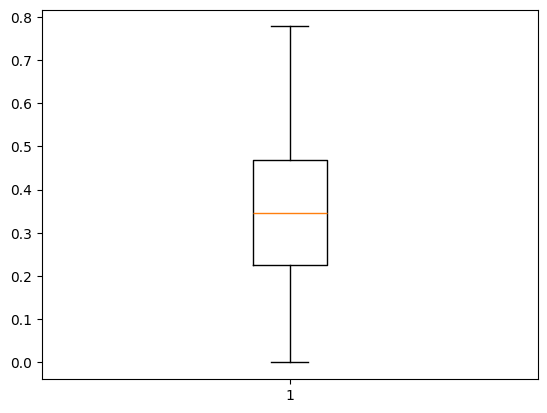

In [ ]:
# Checking if it is useful to calculate picture scores 
# Plot Distributions of the variables 
plt.boxplot(test_df["picture_scores"])

In [ ]:
test_df.corr()

,price,host_is_superhost,picture_scores
price,1.000000,-0.030025,0.003432
host_is_superhost,-0.030025,1.000000,0.110237
picture_scores,0.003432,0.110237,1.000000


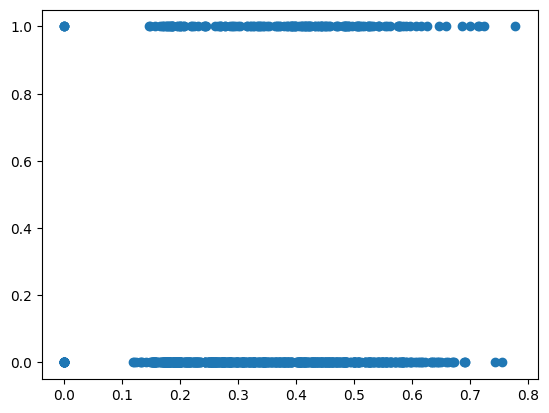

In [ ]:
plt.scatter(test_df["picture_scores"] , test_df["host_is_superhost"])

Can see from the plots above that there isn't any clear or strong realtion ship between the repsonse and the qualtiy of a picture based on the scoring from this API

In [ ]:
# Code to calculate pictures scores if anyone is interested in using for a different purpose

# # Load in dataset to do this part seperately
# df = pd.read_csv("Datasets/AirbnbData/Feature_Engineered_Airbnb.csv")

# # API keys
# client_id = ''
# client_secret = ''

# def calculate_photo_score(photo_url):
#     params = {'url': photo_url}
    
#     quality_ugc = requests.get('https://api.everypixel.com/v1/quality_ugc', params=params, auth=(client_id, client_secret)).json()
#     print(quality_ugc)
#     if quality_ugc["status"] == "ok":
#         return quality_ugc["quality"]["score"]
    
#     return 0.0

 # picture_scores = Parallel(n_jobs=-1)(
 #     delayed(calculate_photo_score)(picture) for picture in tqdm(df["picture_url"], desc="Calculating picture scores")
 # )

# Add pictures scores to dataframe
# df["picture_scores"] = picture_scores